<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/Semi_supervised_classification_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# TensorFlow imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
# Which GPU?
!nvidia-smi

Fri May 15 08:25:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm import tqdm
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Dataset loading
((X_train, y_train), (X_test, y_test)) = tf.keras.datasets.mnist.load_data()
X_train.shape, X_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [0]:
# Add a channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [0]:
# Scale the pixel values to [-1, 1] range as we will be using
# tanh activation in the Generator
X_train = (X_train.astype("float32") - 127.5) / 127.5
X_test = (X_test.astype("float32") - 127.5) / 127.5

In [0]:
# Generate subset of labeled dataset that would be used for the supervised 
# learning task (10 samples per class totalling to 100 samples)
X_train_sub = []
y_train_sub = []
class_labels = np.unique(y_train)

for label in class_labels:
    x_for_class = X_train[y_train==label]
    
    idx = np.random.randint(0, x_for_class.shape[0], 10)
    X_train_sub.append(x_for_class[idx])
    y_train_sub.append([label]*10)

X_train_sub = np.array(X_train_sub).reshape(-1, 28, 28, 1)
y_train_sub = np.array(y_train_sub).reshape(-1, )
print(X_train_sub.shape, y_train_sub.shape)

(100, 28, 28, 1) (100,)


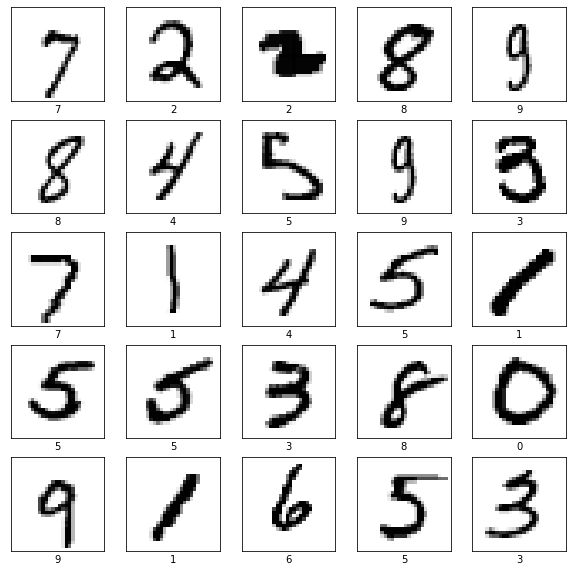

In [0]:
# Visualize
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    idx = np.random.choice(X_train_sub.shape[0], 1, replace=False)
    plt.imshow(X_train_sub[idx].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(int(y_train_sub[idx]))
plt.show()

In [0]:
# Generator
# Reference: Chapter 20, GANs in Python by Jason Brownlee, Chapter 7 of GANs in Action
def generator_network(latent_dim):
    in_lat = Input(shape=(latent_dim,))

    n_nodes = 256 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = Reshape((7, 7, 256))(gen)

    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)

    gen = Conv2DTranspose(64, (3,3), strides=(1,1), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)

    out_layer = Conv2DTranspose(1, (3,3), strides=(2, 2), activation='tanh', padding='same')(gen)

    model = Model(in_lat, out_layer)

    return model

In [0]:
# Discriminator: Shared weights between the supervised classifier and standard discriminator 
# as found in GANs
# Reference: Chapter 20, GANs in Python by Jason Brownlee, Chapter 7 of GANs in Action

# Activation function for the discriminator as proposed in https://arxiv.org/abs/1606.03498
def custom_activation(output):
	logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

def disc_network(in_shape=(28,28,1), n_classes=10):
	in_image = Input(shape=in_shape)
 
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.01)(fe)

	fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.01)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.01)(fe)

	fe = Dropout(0.4)(fe)
	fe = Flatten()(fe)

	fe = Dense(n_classes)(fe)

	# Supervised classifier
	c_out_layer = Activation('softmax')(fe)
	c_model = Model(in_image, c_out_layer)

	# Traditional discriminator as found in GANs
	d_out_layer = Lambda(custom_activation)(fe)
	d_model = Model(in_image, d_out_layer)

	return d_model, c_model

In [0]:
# Generator network
generator = generator_network(latent_dim=128)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1618176   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       295040    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0     

In [0]:
# Discriminator and classifier
disc_network, classifier = disc_network()
print(disc_network.summary())
print(classifier.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7385

In [0]:
# Run forward passes
print(classifier(np.expand_dims(X_train_sub[0], 0)).shape)
print(disc_network(np.expand_dims(X_train_sub[0], 0)).shape)
print(generator(np.random.normal(size=(1, 128))).shape)

(1, 10)
(1, 1)
(1, 28, 28, 1)


In [0]:
# Define the optimizers
c_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [0]:
# Define the loss functions
classifier_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
disc_loss_fn = tf.keras.losses.BinaryCrossentropy()
gan_loss_fn = tf.keras.losses.BinaryCrossentropy()

In [0]:
# Convert to TensorFlow dataset for performance
labeled_subset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_sub, y_train_sub))
    .shuffle(100)
    .batch(16)
    .prefetch(tf.data.experimental.AUTOTUNE)
    
)

unlabeled_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train))
    .shuffle(100)
    .batch(8)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

The shared weights of the classifier and the discriminator would be updated on a set of 32 images:
- 16 images from the set of only hundred labeled examples.
- 8 images from the unlabeled examples.
- 8 fake images generated by the generator. 

In [0]:
@tf.function
def train_classifier(images, labels, classifier, classifier_loss_fn):
    with tf.GradientTape() as tape:
        logits = classifier(images)
        classification_loss = classifier_loss_fn(labels, logits)
    
    grads = tape.gradient(classification_loss, classifier.trainable_weights)
    
    return classification_loss, grads

@tf.function
def train_disc(images, labels, disc_network, disc_loss_fn):
    with tf.GradientTape() as tape:
        logits = disc_network(images)
        disc_loss = disc_loss_fn(labels, logits)
    
    grads = tape.gradient(disc_loss, disc_network.trainable_weights)
    
    return disc_loss, grads

@tf.function
def train_gen(random_latent_vectors, labels, disc_network, generator, gan_loss_fn):
    with tf.GradientTape() as tape:
        logits = disc_network(generator(random_latent_vectors))
        g_loss = gan_loss_fn(labels, logits)

    grads = tape.gradient(g_loss, generator.trainable_weights)
    
    return g_loss, grads

In [0]:
################## Training ##################
##############################################
for epoch in tqdm(range(7500)):
    # Define objects to calculate the mean losses across each epoch
    c_loss_mean = tf.keras.metrics.Mean()
    d_loss_mean = tf.keras.metrics.Mean()
    g_loss_mean = tf.keras.metrics.Mean()
    
    # Train the classifier
    # for (images, labels) in labeled_subset:
    images, labels = next(iter(labeled_subset)) # 16 images
    classification_loss, grads = train_classifier(images, labels, classifier, classifier_loss_fn)
    c_optimizer.apply_gradients(zip(grads, classifier.trainable_weights)) # The shared weights of the classifier and the discriminator will therefore be updated on a total of 32 images
    c_loss_mean.update_state(classification_loss)
        
    ## Train discriminator and generator ##
    #######################################

    # Train discriminator
    real_images = next(iter(unlabeled_dataset)) # 8 real images
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
    
    generated_images = generator(random_latent_vectors) # 8 fake images
    combined_images = tf.concat([generated_images, real_images], axis=0) # 16 total images
    combined_labels = tf.concat(
        [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
    ) # 0 -> Fake images, 1 -> Real images

    disc_loss, grads = train_disc(combined_images, combined_labels, disc_network, disc_loss_fn)
    d_optimizer.apply_gradients(zip(grads, disc_network.trainable_weights)) # The shared weights of the classifier and the discriminator will therefore be updated on a total of 32 images
    d_loss_mean.update_state(disc_loss)

    # Train the generator via signals from the discriminator
    random_latent_vectors = tf.random.normal(shape=(batch_size*4, 128)) # 32 images
    misleading_labels = tf.ones((batch_size*4, 1))

    g_loss, grads = train_gen(random_latent_vectors, misleading_labels, disc_network, generator, gan_loss_fn)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    g_loss_mean.update_state(g_loss)
        
    if epoch % 100 == 0:
        print("epoch: {} classification loss: {:.3f} dicriminator loss: {:.3f} gan loss:{:.3f}".format(
            epoch,
            c_loss_mean.result(),
            d_loss_mean.result(),
            g_loss_mean.result()
        ))

  0%|          | 1/7500 [00:01<3:32:53,  1.70s/it]

epoch: 0 classification loss: 2.296 dicriminator loss: 1.247 gan loss:0.095


  1%|▏         | 102/7500 [00:21<24:24,  5.05it/s]

epoch: 100 classification loss: 0.479 dicriminator loss: 0.026 gan loss:3.863


  3%|▎         | 201/7500 [00:41<24:49,  4.90it/s]

epoch: 200 classification loss: 0.085 dicriminator loss: 0.651 gan loss:1.852


  4%|▍         | 301/7500 [01:01<23:45,  5.05it/s]

epoch: 300 classification loss: 0.074 dicriminator loss: 0.520 gan loss:1.841


  5%|▌         | 402/7500 [01:21<23:35,  5.01it/s]

epoch: 400 classification loss: 0.034 dicriminator loss: 0.652 gan loss:0.615


  7%|▋         | 502/7500 [01:41<22:50,  5.11it/s]

epoch: 500 classification loss: 0.095 dicriminator loss: 0.498 gan loss:1.214


  8%|▊         | 602/7500 [02:01<22:54,  5.02it/s]

epoch: 600 classification loss: 0.015 dicriminator loss: 0.685 gan loss:1.149


  9%|▉         | 701/7500 [02:20<22:44,  4.98it/s]

epoch: 700 classification loss: 0.012 dicriminator loss: 0.651 gan loss:0.987


 11%|█         | 802/7500 [02:41<21:42,  5.14it/s]

epoch: 800 classification loss: 0.010 dicriminator loss: 0.711 gan loss:1.516


 12%|█▏        | 901/7500 [03:01<22:05,  4.98it/s]

epoch: 900 classification loss: 0.008 dicriminator loss: 0.404 gan loss:1.643


 13%|█▎        | 1001/7500 [03:21<21:38,  5.01it/s]

epoch: 1000 classification loss: 0.012 dicriminator loss: 0.460 gan loss:1.218


 15%|█▍        | 1102/7500 [03:41<21:45,  4.90it/s]

epoch: 1100 classification loss: 0.006 dicriminator loss: 0.431 gan loss:1.942


 16%|█▌        | 1202/7500 [04:01<20:42,  5.07it/s]

epoch: 1200 classification loss: 0.018 dicriminator loss: 0.429 gan loss:1.768


 17%|█▋        | 1301/7500 [04:21<21:02,  4.91it/s]

epoch: 1300 classification loss: 0.007 dicriminator loss: 0.332 gan loss:1.371


 19%|█▊        | 1401/7500 [04:41<20:28,  4.96it/s]

epoch: 1400 classification loss: 0.003 dicriminator loss: 0.299 gan loss:1.767


 20%|██        | 1501/7500 [05:01<20:18,  4.92it/s]

epoch: 1500 classification loss: 0.007 dicriminator loss: 0.449 gan loss:2.181


 21%|██▏       | 1601/7500 [05:21<19:56,  4.93it/s]

epoch: 1600 classification loss: 0.010 dicriminator loss: 0.327 gan loss:1.117


 23%|██▎       | 1702/7500 [05:42<19:33,  4.94it/s]

epoch: 1700 classification loss: 0.005 dicriminator loss: 0.404 gan loss:1.412


 24%|██▍       | 1802/7500 [06:02<19:15,  4.93it/s]

epoch: 1800 classification loss: 0.001 dicriminator loss: 0.083 gan loss:1.713


 25%|██▌       | 1901/7500 [06:22<19:04,  4.89it/s]

epoch: 1900 classification loss: 0.005 dicriminator loss: 0.409 gan loss:2.277


 27%|██▋       | 2001/7500 [06:43<18:26,  4.97it/s]

epoch: 2000 classification loss: 0.003 dicriminator loss: 0.153 gan loss:1.876


 28%|██▊       | 2102/7500 [07:03<18:03,  4.98it/s]

epoch: 2100 classification loss: 0.001 dicriminator loss: 0.211 gan loss:1.940


 29%|██▉       | 2202/7500 [07:23<17:34,  5.03it/s]

epoch: 2200 classification loss: 0.001 dicriminator loss: 0.126 gan loss:2.485


 31%|███       | 2301/7500 [07:43<17:34,  4.93it/s]

epoch: 2300 classification loss: 0.001 dicriminator loss: 0.167 gan loss:1.345


 32%|███▏      | 2402/7500 [08:03<16:58,  5.00it/s]

epoch: 2400 classification loss: 0.001 dicriminator loss: 0.436 gan loss:2.051


 33%|███▎      | 2502/7500 [08:23<16:12,  5.14it/s]

epoch: 2500 classification loss: 0.001 dicriminator loss: 0.135 gan loss:3.063


 35%|███▍      | 2601/7500 [08:43<16:16,  5.01it/s]

epoch: 2600 classification loss: 0.001 dicriminator loss: 0.434 gan loss:1.797


 36%|███▌      | 2702/7500 [09:04<16:00,  5.00it/s]

epoch: 2700 classification loss: 0.001 dicriminator loss: 0.358 gan loss:1.409


 37%|███▋      | 2802/7500 [09:24<15:27,  5.06it/s]

epoch: 2800 classification loss: 0.001 dicriminator loss: 0.233 gan loss:2.771


 39%|███▊      | 2901/7500 [09:44<15:31,  4.94it/s]

epoch: 2900 classification loss: 0.000 dicriminator loss: 0.267 gan loss:3.227


 40%|████      | 3001/7500 [10:04<15:25,  4.86it/s]

epoch: 3000 classification loss: 0.001 dicriminator loss: 0.368 gan loss:3.106


 41%|████▏     | 3102/7500 [10:24<14:36,  5.02it/s]

epoch: 3100 classification loss: 0.000 dicriminator loss: 0.315 gan loss:2.677


 43%|████▎     | 3201/7500 [10:44<14:11,  5.05it/s]

epoch: 3200 classification loss: 0.000 dicriminator loss: 0.200 gan loss:1.925


 44%|████▍     | 3301/7500 [11:04<13:58,  5.01it/s]

epoch: 3300 classification loss: 0.000 dicriminator loss: 0.119 gan loss:2.962


 45%|████▌     | 3402/7500 [11:24<13:50,  4.93it/s]

epoch: 3400 classification loss: 0.001 dicriminator loss: 0.359 gan loss:3.104


 47%|████▋     | 3502/7500 [11:44<13:19,  5.00it/s]

epoch: 3500 classification loss: 0.000 dicriminator loss: 0.273 gan loss:2.321


 48%|████▊     | 3601/7500 [12:05<13:13,  4.91it/s]

epoch: 3600 classification loss: 0.000 dicriminator loss: 0.217 gan loss:2.250


 49%|████▉     | 3702/7500 [12:25<12:32,  5.05it/s]

epoch: 3700 classification loss: 0.000 dicriminator loss: 0.337 gan loss:2.053


 51%|█████     | 3801/7500 [12:45<12:25,  4.96it/s]

epoch: 3800 classification loss: 0.000 dicriminator loss: 0.207 gan loss:1.396


 52%|█████▏    | 3901/7500 [13:05<11:53,  5.04it/s]

epoch: 3900 classification loss: 0.000 dicriminator loss: 0.195 gan loss:3.388


 53%|█████▎    | 4002/7500 [13:25<11:39,  5.00it/s]

epoch: 4000 classification loss: 0.000 dicriminator loss: 0.183 gan loss:2.865


 55%|█████▍    | 4101/7500 [13:45<11:20,  4.99it/s]

epoch: 4100 classification loss: 0.000 dicriminator loss: 0.207 gan loss:3.039


 56%|█████▌    | 4202/7500 [14:05<11:00,  5.00it/s]

epoch: 4200 classification loss: 0.000 dicriminator loss: 0.175 gan loss:1.599


 57%|█████▋    | 4302/7500 [14:26<10:49,  4.92it/s]

epoch: 4300 classification loss: 0.000 dicriminator loss: 0.211 gan loss:2.937


 59%|█████▊    | 4401/7500 [14:45<10:20,  4.99it/s]

epoch: 4400 classification loss: 0.000 dicriminator loss: 0.455 gan loss:1.393


 60%|██████    | 4502/7500 [15:06<10:08,  4.93it/s]

epoch: 4500 classification loss: 0.000 dicriminator loss: 0.123 gan loss:2.467


 61%|██████▏   | 4601/7500 [15:26<09:42,  4.97it/s]

epoch: 4600 classification loss: 0.000 dicriminator loss: 0.251 gan loss:2.894


 63%|██████▎   | 4702/7500 [15:46<09:10,  5.08it/s]

epoch: 4700 classification loss: 0.000 dicriminator loss: 0.266 gan loss:2.754


 64%|██████▍   | 4802/7500 [16:06<09:05,  4.94it/s]

epoch: 4800 classification loss: 0.000 dicriminator loss: 0.843 gan loss:1.226


 65%|██████▌   | 4902/7500 [16:27<08:48,  4.91it/s]

epoch: 4900 classification loss: 0.000 dicriminator loss: 0.263 gan loss:3.650


 67%|██████▋   | 5001/7500 [16:47<08:29,  4.90it/s]

epoch: 5000 classification loss: 0.000 dicriminator loss: 0.059 gan loss:3.386


 68%|██████▊   | 5101/7500 [17:07<08:09,  4.90it/s]

epoch: 5100 classification loss: 0.000 dicriminator loss: 0.195 gan loss:2.337


 69%|██████▉   | 5201/7500 [17:27<07:40,  5.00it/s]

epoch: 5200 classification loss: 0.000 dicriminator loss: 0.214 gan loss:2.894


 71%|███████   | 5301/7500 [17:47<07:23,  4.96it/s]

epoch: 5300 classification loss: 0.000 dicriminator loss: 0.085 gan loss:3.421


 72%|███████▏  | 5401/7500 [18:07<06:57,  5.03it/s]

epoch: 5400 classification loss: 0.000 dicriminator loss: 0.196 gan loss:2.272


 73%|███████▎  | 5502/7500 [18:27<06:24,  5.19it/s]

epoch: 5500 classification loss: 0.000 dicriminator loss: 0.160 gan loss:3.685


 75%|███████▍  | 5602/7500 [18:47<06:15,  5.05it/s]

epoch: 5600 classification loss: 0.000 dicriminator loss: 0.048 gan loss:3.063


 76%|███████▌  | 5702/7500 [19:07<05:58,  5.01it/s]

epoch: 5700 classification loss: 0.000 dicriminator loss: 0.038 gan loss:3.700


 77%|███████▋  | 5801/7500 [19:26<05:48,  4.87it/s]

epoch: 5800 classification loss: 0.000 dicriminator loss: 0.292 gan loss:1.979


 79%|███████▊  | 5902/7500 [19:47<05:18,  5.02it/s]

epoch: 5900 classification loss: 0.000 dicriminator loss: 0.324 gan loss:2.544


 80%|████████  | 6002/7500 [20:06<05:00,  4.99it/s]

epoch: 6000 classification loss: 0.000 dicriminator loss: 0.334 gan loss:3.646


 81%|████████▏ | 6101/7500 [20:26<04:36,  5.05it/s]

epoch: 6100 classification loss: 0.000 dicriminator loss: 0.095 gan loss:4.248


 83%|████████▎ | 6202/7500 [20:47<04:13,  5.12it/s]

epoch: 6200 classification loss: 0.000 dicriminator loss: 0.237 gan loss:3.198


 84%|████████▍ | 6301/7500 [21:06<04:03,  4.93it/s]

epoch: 6300 classification loss: 0.000 dicriminator loss: 0.494 gan loss:3.282


 85%|████████▌ | 6402/7500 [21:27<03:37,  5.04it/s]

epoch: 6400 classification loss: 0.000 dicriminator loss: 0.345 gan loss:3.137


 87%|████████▋ | 6502/7500 [21:46<03:19,  5.01it/s]

epoch: 6500 classification loss: 0.000 dicriminator loss: 0.087 gan loss:2.884


 88%|████████▊ | 6601/7500 [22:06<02:55,  5.14it/s]

epoch: 6600 classification loss: 0.000 dicriminator loss: 0.350 gan loss:2.345


 89%|████████▉ | 6701/7500 [22:25<02:38,  5.06it/s]

epoch: 6700 classification loss: 0.000 dicriminator loss: 0.095 gan loss:3.918


 91%|█████████ | 6802/7500 [22:45<02:17,  5.09it/s]

epoch: 6800 classification loss: 0.000 dicriminator loss: 0.179 gan loss:3.326


 92%|█████████▏| 6902/7500 [23:05<01:58,  5.05it/s]

epoch: 6900 classification loss: 0.000 dicriminator loss: 0.257 gan loss:2.005


 93%|█████████▎| 7002/7500 [23:25<01:38,  5.06it/s]

epoch: 7000 classification loss: 0.000 dicriminator loss: 0.287 gan loss:2.987


 95%|█████████▍| 7101/7500 [23:45<01:18,  5.10it/s]

epoch: 7100 classification loss: 0.000 dicriminator loss: 0.517 gan loss:2.179


 96%|█████████▌| 7201/7500 [24:05<00:59,  5.05it/s]

epoch: 7200 classification loss: 0.000 dicriminator loss: 0.078 gan loss:2.580


 97%|█████████▋| 7302/7500 [24:25<00:38,  5.10it/s]

epoch: 7300 classification loss: 0.000 dicriminator loss: 0.180 gan loss:2.356


 99%|█████████▊| 7402/7500 [24:44<00:19,  5.05it/s]

epoch: 7400 classification loss: 0.000 dicriminator loss: 0.117 gan loss:3.948


100%|██████████| 7500/7500 [25:03<00:00,  4.99it/s]


In [0]:
# Performance on the entire training set
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
accuracy_metric.update_state(y_train, classifier.predict(X_train))
print("Accuracy for the full training set {:.3f}%".format(accuracy_metric.result().numpy()*100))

Accuracy for the full training set 75.950%


In [0]:
# Performance on the entire test set
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
accuracy_metric.update_state(y_test, classifier.predict(X_test))
print("Accuracy for the full test set {:.3f}%".format(accuracy_metric.result().numpy()*100))

Accuracy for the full test set 76.010%


Training for longer would have enhanced this performance even more but _we would need to be careful there to not make the model overfit in that process_. Let's now see how a fully supervised classifier would have done with just 100 labled images.  

In [0]:
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .shuffle(100)
    .batch(16)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
# Just the classifier
_, classifier = disc_network()
classifier.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# An EarlyStopping callback for preventing overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

# Train the model
classifier.fit(labeled_subset,
               validation_data=test_ds,
               epochs=50,
               callbacks=[es])

Epoch 1/50
7/7 [==============================] - 2s 319ms/step - loss: 2.4855 - accuracy: 0.2200 - val_loss: 2.2490 - val_accuracy: 0.2803
Epoch 2/50
7/7 [==============================] - 2s 297ms/step - loss: 0.8860 - accuracy: 0.7300 - val_loss: 2.2019 - val_accuracy: 0.3351
Epoch 3/50
7/7 [==============================] - 2s 301ms/step - loss: 0.3363 - accuracy: 0.9300 - val_loss: 2.1652 - val_accuracy: 0.4759
Epoch 4/50
7/7 [==============================] - 2s 289ms/step - loss: 0.2425 - accuracy: 0.9600 - val_loss: 2.1368 - val_accuracy: 0.4564
Epoch 5/50
7/7 [==============================] - 2s 267ms/step - loss: 0.1478 - accuracy: 0.9900 - val_loss: 2.1174 - val_accuracy: 0.3308
Epoch 6/50
7/7 [==============================] - 2s 268ms/step - loss: 0.0708 - accuracy: 1.0000 - val_loss: 2.1032 - val_accuracy: 0.4010
Epoch 7/50
7/7 [==============================] - 2s 266ms/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 2.0922 - val_accuracy: 0.4477
Epoch 8/50
7/7 [====

If you run into errors due to this line - `_, classifier = disc_network()`, just rerun `disc_network()` method.

In [0]:
print("Accuracy on the full training dataset: {:.3f}%".format(classifier.evaluate(X_train, y_train)[1]*100))
print("Accuracy on the full training dataset: {:.3f}%".format(classifier.evaluate(X_test, y_test)[1]*100))

1875/1875 [==============================] - 6s 3ms/step - loss: 1.0614 - accuracy: 0.7245
Accuracy on the full training dataset: 72.447%
313/313 [==============================] - 1s 3ms/step - loss: 1.0431 - accuracy: 0.7306
Accuracy on the full training dataset: 73.060%
